# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [1]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-03-25 11:58:25--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.112.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 533309 (521K) [text/plain]
Сохранение в: «russian-train-high»

russian-train-high  100%[===================>] 520,81K   350KB/s    за 1,5s    

2020-03-25 11:58:27 (350 KB/s) - «russian-train-high» сохранён [533309/533309]

--2020-03-25 11:58:27--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.112.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 53671 (52K) [text/plain]
Сохранен

**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [1]:
def read_infile(infile):
    """
    == MY CODE HERE ==
    """
    words = []
    with open(infile, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            splited_line = line.split()
            if len(splited_line )==3:
                words.append(splited_line[1].lower())
    return words

In [2]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

9213 917 922
валлонскому незаконченным истрёпывав личного серьгам необоснованным тюти заросла идеальна гулкой


**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [3]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary
"""
== MY CODE HERE ==
"""
vocab = SimpleVocabulary(special_tokens=('PAD', 'BEGIN', 'END'), 
                         unk_token='UNK', save_path='./tmp')

vocab.fit([list(x) for x in train_words])
print(len(vocab))

2020-03-25 19:19:13.966 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead


37


**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [4]:
import torch
from torch.utils.data import Dataset as TorchDataset
  
class Dataset(TorchDataset):
    """Custom data.Dataset compatible with data.DataLoader."""

    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.
        """
        word = self.data[index]
        batch = self.vocab.__call__(['BEGIN'] + list(word) + ['END'])
        return (torch.LongTensor(batch[:-1]), torch.LongTensor(batch[1:]))

    def __len__(self):
        return len(self.data)

In [5]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [6]:
from torch.utils.data import DataLoader

"""
== MY CODE HERE ==
"""


train_loader = DataLoader(train_dataset, batch_size=1)
dev_loader = DataLoader(dev_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)


In [7]:
        
for batch, i in zip(train_loader, range(10)):
    print (batch[0].shape, batch[1].shape)

torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 14]) torch.Size([1, 14])
torch.Size([1, 11]) torch.Size([1, 11])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 15]) torch.Size([1, 15])
torch.Size([1, 5]) torch.Size([1, 5])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 9]) torch.Size([1, 9])
torch.Size([1, 7]) torch.Size([1, 7])


**(1.5) 1 point** Explain, why this does not work with larger batch size.

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [8]:
import numpy as np

def pad_tensor(vec, length, dim, pad_symbol):
    """
    Pads a vector ``vec`` up to length ``length`` along axis ``dim`` with pad symbol ``pad_symbol``.
    """
    """
    == MY CODE HERE ==
    """
    output_dims = list(vec.shape)
    pad = np.zeros((len(output_dims)*2,)).astype(int).tolist()
    k = len(output_dims)-dim-1
    pad[2*k+1] = length-output_dims[dim]
    return torch.nn.functional.pad(vec, pad, mode='constant', value=pad_symbol)

class Padder:
    
    def __init__(self, dim=0, pad_symbol=0, length=None):
        self.dim = dim
        self.pad_symbol = pad_symbol
        self.length = length
    def __call__(self, batch):
        """
        == MY CODE HERE ==
        """
        if self.length is None:
            length = sorted([term[0].shape[self.dim] for term in batch])[-1]
        else:
            length = self.length
        source = torch.stack([pad_tensor(term[0], length, self.dim, self.pad_symbol) for term in batch])
        targets = torch.stack([pad_tensor(term[1], length, self.dim, self.pad_symbol) for term in batch])
        return [source, targets]

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [9]:
from torch.utils.data import DataLoader

"""
== MY CODE HERE ==
"""
pad_symb=vocab._t2i['PAD']
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=Padder(pad_symbol=pad_symb))
dev_loader = DataLoader(dev_dataset, batch_size=32, collate_fn=Padder(pad_symbol=pad_symb))
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=Padder(pad_symbol=pad_symb))

In [10]:
        
for batch, i in zip(train_loader, range(10)):
    print (batch[0].shape, batch[1].shape)

torch.Size([32, 16]) torch.Size([32, 16])
torch.Size([32, 18]) torch.Size([32, 18])
torch.Size([32, 16]) torch.Size([32, 16])
torch.Size([32, 17]) torch.Size([32, 17])
torch.Size([32, 19]) torch.Size([32, 19])
torch.Size([32, 16]) torch.Size([32, 16])
torch.Size([32, 17]) torch.Size([32, 17])
torch.Size([32, 18]) torch.Size([32, 18])
torch.Size([32, 16]) torch.Size([32, 16])
torch.Size([32, 19]) torch.Size([32, 19])


## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [11]:
import torch.nn as nn

class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size, batch_size, device):
        super(RNNLM, self).__init__()
        """
        == MY CODE HERE ==
        """
        self.vocab_size = vocab_size
        self.embeddings_dim = embeddings_dim
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.device = device
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embeddings_dim)
        self.gru = nn.GRU(input_size=self.embeddings_dim, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)#Softmax doesn't work directly with NLLLoss
        
    def forward(self, inputs, hidden=None):
        """
        == MY CODE HERE ==
        """
        if hidden is None:
            hidden = self.init_hidden(inputs.shape)
        outputs = self.embedding(inputs)
        outputs, hidden = self.gru(outputs)
        outputs = self.linear(outputs)
        outputs = self.softmax(outputs)
        return outputs, hidden

    def init_hidden(self, inputs_shape):
        return torch.zeros(1, inputs_shape[0], self.embeddings_dim, device = self.device)


**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [12]:
def validate_on_batch(model, criterion, x, y):
    """
    == MY CODE HERE ==
    """
    x = x.to(device)
    y = y.to(device)
    predictions, _ = model(x)
    return criterion(predictions.reshape(predictions.shape[0] * predictions.shape[1], -1), 
                     y.reshape(predictions.shape[1] * predictions.shape[0]))


**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [13]:
def train_on_batch(model, criterion, x, y, optimizer):
    """
    == MY CODE HERE ==
    """
    model.train()
    optimizer.zero_grad()
    loss = validate_on_batch(model, criterion, x, y)
    loss.backward()
    optimizer.step()
    return np.mean(loss.item())

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

In [14]:
"""
== MY CODE HERE ==
"""

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.set_device(2)
else:
    device = 'cpu'


print("device: ", device)

device:  cuda


In [15]:
batch_size = 32
learning_rate = 0.001
num_epochs = 300
train_loss = []
val_loss = []

rnnlm = RNNLM(vocab_size=len(vocab), embeddings_dim=len(vocab), hidden_size=200, batch_size=batch_size, device=device)
rnnlm.to(device)

weights = torch.ones((len(vocab),)).to(device)
weights[pad_symb]  = 0
criterion = nn.NLLLoss(weight=weights, reduction='mean')
optimizer = torch.optim.Adam(rnnlm.parameters(), lr=learning_rate)
rnnlm.to(device)

RNNLM(
  (embedding): Embedding(37, 37)
  (gru): GRU(37, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=37, bias=True)
  (softmax): LogSoftmax()
)

In [16]:
for epoch in range(num_epochs):
    iterations_train = 0
    train_loss_iter = 0
    val_loss_iter = 0
    for ind, (x, y) in enumerate(train_loader):
        train_loss_iter += train_on_batch(rnnlm, criterion, x, y, optimizer)
        iterations_train += 1
        torch.cuda.empty_cache()
    for ind, (x, y) in enumerate(dev_loader):
        rnnlm.eval()
        val_loss_iter = validate_on_batch(rnnlm, criterion, x, y)
        torch.cuda.empty_cache()
    train_loss.append(train_loss_iter / iterations_train)
    val_loss.append(val_loss_iter)
    if epoch%100 == 0:
        print("Epoch {}: train_loss = {}, val_loss = {}".format(epoch, train_loss[-1], val_loss[-1]))
        

Epoch 0: train_loss = 2.5524325031373234, val_loss = 2.3009464740753174
Epoch 100: train_loss = 1.075096734902925, val_loss = 2.998997926712036
Epoch 200: train_loss = 1.0400415677577257, val_loss = 3.129255533218384


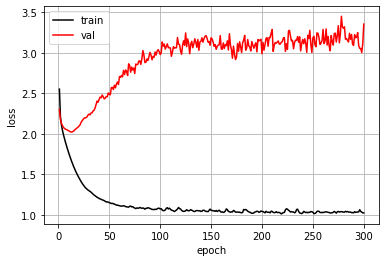

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(np.arange(1,len(train_loss)+1), train_loss, label='train', color='black')
ax.plot(np.arange(1,len(val_loss)+1), val_loss, label='val', color='red')

ax.set(ylabel='loss', xlabel='epoch')
ax.grid()
plt.legend()
plt.show()


**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [18]:
"""
== MY CODE HERE ==
"""

def predict_on_batch(model, batch, hidden=None, dim=0):
    model.eval()
    batch = batch.to(device)
    preds, hidden = model(batch, hidden)
    softmax = nn.Softmax(dim=dim)
    return (softmax(preds), hidden)

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

In [23]:
"""
== MY CODE HERE ==
"""
length = max(map(lambda x: x[0].shape[-1], test_dataset))
test_loader = DataLoader(train_dataset, batch_size=32, shuffle = False, collate_fn=Padder(length=length, pad_symbol=3))
probs = None
hidden = None

for ind, (x, y) in enumerate(test_loader): 
    if ind == 0:
        probs, hidden = predict_on_batch(rnnlm, x)
    else:
        hidden = hidden[:, :x.shape[0], :]
        preds, hidden = predict_on_batch(rnnlm, x, hidden=hidden)
        probs = torch.cat((probs, preds))

In [24]:
for i in range(-20, 0):
    word = test_dataset.data[i]
    print("word: ", word)
    for j, letter in enumerate(word):
        print('letter {} : probability {}'.format(letter, probs[i, j, vocab(letter)]))

word:  пшеничной
letter п : probability 0.03448275849223137
letter ш : probability 1.1459667348390212e-07
letter е : probability 1.1635414011834655e-05
letter н : probability 1.4664968830402358e-06
letter и : probability 5.683313020199421e-07
letter ч : probability 0.19576825201511383
letter н : probability 0.0001208367757499218
letter о : probability 3.7104319616787507e-10
letter й : probability 4.247155405145975e-11
word:  переживаниями
letter п : probability 0.03448275849223137
letter е : probability 6.881132321723271e-06
letter р : probability 0.027759699150919914
letter е : probability 0.0003513515694066882
letter ж : probability 0.00031770026544108987
letter и : probability 1.9106200852547772e-06
letter в : probability 1.0008609052647444e-08
letter а : probability 1.3751672023332162e-09
letter н : probability 1.9646162474629136e-09
letter и : probability 5.974822215648601e-06
letter я : probability 2.219669864578222e-10
letter м : probability 0.015115627087652683
letter и : proba

**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [25]:
def generate(model, max_length=20, start_index=1, end_index=2, pad_index=0):
    """
    == MY CODE HERE ==
    """
    model.eval()
    previous_letter = start_index
    word = []
    hidden=None
    
    for i in range(length):
        ind = torch.tensor([previous_letter])[None, :]
        prob, hidden = predict_on_batch(model, ind, hidden)
        previous_letter = torch.multinomial(prob.squeeze(), 1)
        if previous_letter in [start_index, end_index, pad_index]:
            return ''.join(word)
        previous_letter = previous_letter.cpu().numpy()[0]
        word.append(vocab(previous_letter))
    return ''.join(word)

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [29]:
for i in range(20):
    """
    == MY CODE HERE ==
    """
    print(generate(rnnlm))

ищумтьммиуъмя
от
влфлй
рюфйсзлыпь
ккцы
йъдда
спияйзлм
ъпучф
энйш-оп
в-
аьижвгб
еебыызхпыыджю
ёеьж
оывккъгорц-ч-ф
лйкоыюсшгзщзж
ф
ь-мёчеэйхкпхш
аынлтёэхъщас
плсцкхецн



**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [30]:
def generate_batch(model, batch_size, max_length=20, start_index=1, end_index=2, pad_index=0):
    """
    == MY CODE HERE ==
    """
    state = torch.tensor([start_index for i in range(batch_size)]).reshape(batch_size, 1)
    generated_words = []
    generated = None
    hidden = None
    
    for i in range(max_length):
        probs, hidden = predict_on_batch(model, state, hidden)
        state = torch.multinomial(probs.squeeze(), num_samples=1)
        if i == 0:
            generated = state[None, :]
        else:
            generated = torch.cat((generated, state[None, :]))
    for i in range(batch_size):
        tensor = generated[:, i, 0]
        last_pos = max_length
        for j in range(max_length):
            if tensor[j] in [start_index, end_index, pad_index]:
                last_pos = j
                break
        generated_words.append(''.join([vocab(val.item()) for val in tensor[:last_pos]]))
    return generated_words

In [32]:
generate_batch(rnnlm, 20)

['стёбю',
 'нц-ээфе',
 'тьсть',
 'калишьфечёмыьфекучаг',
 'гн-пр',
 'ть',
 '',
 'озъ',
 'э',
 'ышеча',
 'нямы',
 'чаэвямы',
 'ц-прутёщёмы-пьвьфеди',
 'уть',
 'ёгай',
 '-э',
 'ходзы-кодяжджутимых-',
 'бю',
 'няшь',
 '-пёбекутишапцизый']

**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.

In [33]:
class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size, batch_size, device):
        super(RNNLM, self).__init__()
        """
        == MY CODE HERE ==
        """
        self.vocab_size = vocab_size
        self.embeddings_dim = embeddings_dim
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.device = device
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embeddings_dim)
        self.lstm = nn.LSTM(input_size=self.embeddings_dim, hidden_size=self.hidden_size, dropout=0.5, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, inputs, hidden=None):
        """
        == MY CODE HERE ==
        """
        if hidden is None:
            hidden = self.init_hidden(inputs.shape)
        outputs = self.embedding(inputs)
        outputs, hidden = self.lstm(outputs)
        outputs = self.linear(outputs)
        outputs = self.softmax(outputs)
        return outputs, hidden

    def init_hidden(self, inputs_shape):
        return torch.zeros(1, inputs_shape[0], self.embeddings_dim, device = self.device)

In [37]:
batch_size = 32
learning_rate = 0.00001
num_epochs = 500
train_loss = []
val_loss = []

rnnlm = RNNLM(vocab_size=len(vocab), embeddings_dim=len(vocab), hidden_size=200, batch_size=batch_size, device=device)
rnnlm.to(device)

weights = torch.ones((len(vocab),)).to(device)
weights[pad_symb]  = 0
criterion = nn.NLLLoss(weight=weights, reduction='mean')
optimizer = torch.optim.Adam(rnnlm.parameters(), lr=learning_rate)
rnnlm.to(device)

/home/tanos/.conda/envs/OCR/lib/python3.7/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNNLM(
  (embedding): Embedding(37, 37)
  (lstm): LSTM(37, 200, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=200, out_features=37, bias=True)
  (softmax): LogSoftmax()
)

In [38]:
for epoch in range(num_epochs):
    iterations_train = 0
    train_loss_iter = 0
    val_loss_iter = 0
    for ind, (x, y) in enumerate(train_loader):
        train_loss_iter += train_on_batch(rnnlm, criterion, x, y, optimizer)
        iterations_train += 1
        torch.cuda.empty_cache()
    for ind, (x, y) in enumerate(dev_loader):
        rnnlm.eval()
        val_loss_iter = validate_on_batch(rnnlm, criterion, x, y)
        torch.cuda.empty_cache()
    train_loss.append(train_loss_iter / iterations_train)
    val_loss.append(val_loss_iter)
    if epoch%100 == 0:
        print("Epoch {}: train_loss = {}, val_loss = {}".format(epoch, train_loss[-1], val_loss[-1]))

Epoch 0: train_loss = 3.5853831006420984, val_loss = 3.5625903606414795
Epoch 100: train_loss = 2.3121247266729674, val_loss = 2.3471498489379883
Epoch 200: train_loss = 2.1600408164991274, val_loss = 2.1885852813720703
Epoch 300: train_loss = 2.07509578888615, val_loss = 2.124354362487793
Epoch 400: train_loss = 2.013995980636941, val_loss = 2.0901968479156494


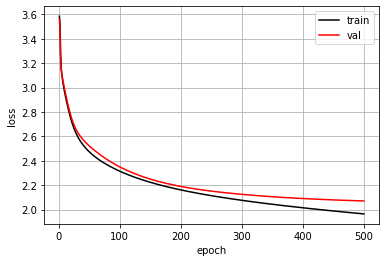

In [39]:
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(train_loss)+1), train_loss, label='train', color='black')
ax.plot(np.arange(1,len(val_loss)+1), val_loss, label='val', color='red')

ax.set(ylabel='loss', xlabel='epoch')
ax.grid()
plt.legend()
plt.show()

In [46]:
generate_batch(rnnlm, 20)

['бойхцыцб',
 'скахжбй-глцишэшю',
 'эказждтязн',
 'ъмтеслюлясб',
 'бхпимпжнфигфещчёгрют',
 'ъвю',
 'ёмддимю',
 'эы',
 'ъпопуйувдвёмышь',
 'шёцвыцлмуамнобляйши',
 'ю',
 'ю',
 'цтэ-жуб',
 'хюьшерузубчюшсёмныйс',
 'йтъёбюди-чъжи',
 'яцыфшьб-кучля-чкна-м',
 'езрютяэщнепр',
 'могуся',
 'аъшфуёнаэжеяжчпизвьщ',
 'ъшткбуццыпуштбогюндф']